# Using  FER2013 DataSet and AffectNet Subsample to train and validate

### Training Emotion Detector

In [5]:
from __future__ import print_function

import os

from time import sleep

import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, ELU, Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.utils import load_img, img_to_array

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from os import listdir
from os.path import isfile, join
import re

In [6]:
cv2.__version__

'4.6.0'

In [7]:
## initializing 

Updating filepaths to point to updated dataset

In [8]:
num_classes = 7
img_rows, img_cols = 48, 48
# keeping batch size at 512 - efficiency does not improve at 1024...
batch_size = 512


#initial model directories
train1_data_dir = './Data/archive_FER_Affect/train/'
validation1_data_dir = '../Data/archive_FER_Affect/test/'

In [9]:
train2_data_dir = './Data/archive_FER_Affect/train2/'
validation2_data_dir = './Data/archive_FER_Affect/test2/'

Both models require data augmentation to rescale the AffectNet images, so CPU power will reduce learning rate given the size of the dataset. In order to avoid it slowing too much, I'm only using horizontal flip as an additional augmenting step at first given the size. The model weights from this model will inform the next model, which will have less images but more augmentation applied.

In [10]:


# Let's use some data augmentaiton 
# train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

#Initial train generator only uses horizontal flip for data augmentation due to the size of the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train1_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation1_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')



Found 38596 images belonging to 7 classes.
Found 9074 images belonging to 7 classes.


In [11]:
print(validation_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Building a new final testing generator for proof of model success on unseen data

In [12]:
test_data_dir = './Data/archive_FER_Affect/final_test/'

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 4163 images belonging to 7 classes.


Now, building data generators for the second model that will use data augmentation

In [15]:
#This second train generator adds in more data augmentation steps in order to increase sample size
train2_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

train2_generator = train2_datagen.flow_from_directory(
        train2_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Let's use some data augmentaiton 
# train_datagen = ImageDataGenerator(rescale=1./255)
val2_datagen = ImageDataGenerator(rescale=1./255)

validation2_generator = val2_datagen.flow_from_directory(
        validation2_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 9601 images belonging to 7 classes.
Found 2276 images belonging to 7 classes.


In [16]:
print(validation2_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


For this first round building the model, we won't change any parameters from the first model

In [17]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)    

2022-09-26 15:04:32.600389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 15:04:32.600605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training our model

In [18]:
# Model 1 train/validation
# - 38596 images belonging to 7 classes
# - 9074 images belonging to 7 classes

In [19]:
# If you want to train the same model or try other models, go for this

filepath = os.path.join("./Data/emotion_detector_models/charlie_model/second_model_initial_weights.h5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
# if mode == "train":
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 38596
nb_validation_samples = 9074
# We start with 100 epochs to reduce inital model run time to avoid losing progress if the model crashes with higher epochs - final model will increase epochs
epochs = 100
model_info = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')


Epoch 1/100


2022-09-26 15:05:05.619367: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 15:05:05.911006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 1.9692 - accuracy: 0.1600

2022-09-26 15:07:18.342911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 160s 2s/step - loss: 1.9692 - accuracy: 0.1600 - val_loss: 1.9643 - val_accuracy: 0.1875
Epoch 2/100
75/75 [==============================] - 157s 2s/step - loss: 1.9410 - accuracy: 0.1899 - val_loss: 1.9059 - val_accuracy: 0.2213
Epoch 3/100
75/75 [==============================] - 158s 2s/step - loss: 1.8728 - accuracy: 0.2555 - val_loss: 1.8502 - val_accuracy: 0.2718
Epoch 4/100
75/75 [==============================] - 159s 2s/step - loss: 1.8159 - accuracy: 0.2901 - val_loss: 1.8084 - val_accuracy: 0.3032
Epoch 5/100
75/75 [==============================] - 166s 2s/step - loss: 1.7709 - accuracy: 0.3239 - val_loss: 1.7739 - val_accuracy: 0.3272
Epoch 6/100
75/75 [==============================] - 173s 2s/step - loss: 1.7374 - accuracy: 0.3464 - val_loss: 1.7395 - val_accuracy: 0.3469
Epoch 7/100
75/75 [==============================] - 392s 5s/step - loss: 1.7023 - accuracy: 0.3668 - val_loss: 1.7107 - val_accuracy: 0.3633
Epoch 8/100
75/75 

75/75 [==============================] - 157s 2s/step - loss: 1.4621 - accuracy: 0.4815 - val_loss: 1.5158 - val_accuracy: 0.4647
Epoch 29/100
75/75 [==============================] - 158s 2s/step - loss: 1.4619 - accuracy: 0.4830 - val_loss: 1.4981 - val_accuracy: 0.4716
Epoch 30/100
75/75 [==============================] - 176s 2s/step - loss: 1.4562 - accuracy: 0.4863 - val_loss: 1.4901 - val_accuracy: 0.4753
Epoch 31/100
75/75 [==============================] - 172s 2s/step - loss: 1.4507 - accuracy: 0.4886 - val_loss: 1.4903 - val_accuracy: 0.4710
Epoch 32/100
75/75 [==============================] - 768s 10s/step - loss: 1.4475 - accuracy: 0.4900 - val_loss: 1.4805 - val_accuracy: 0.4755
Epoch 33/100
75/75 [==============================] - 156s 2s/step - loss: 1.4419 - accuracy: 0.4909 - val_loss: 1.4730 - val_accuracy: 0.4789
Epoch 34/100
75/75 [==============================] - 156s 2s/step - loss: 1.4342 - accuracy: 0.4970 - val_loss: 1.4765 - val_accuracy: 0.4789
Epoch 35/10

Epoch 56/100
75/75 [==============================] - 157s 2s/step - loss: 1.3789 - accuracy: 0.5206 - val_loss: 1.4309 - val_accuracy: 0.4977
Epoch 57/100
75/75 [==============================] - 158s 2s/step - loss: 1.3738 - accuracy: 0.5222 - val_loss: 1.4391 - val_accuracy: 0.4920
Epoch 58/100
75/75 [==============================] - 157s 2s/step - loss: 1.3735 - accuracy: 0.5247 - val_loss: 1.4387 - val_accuracy: 0.4960
Epoch 59/100
75/75 [==============================] - 157s 2s/step - loss: 1.3706 - accuracy: 0.5249 - val_loss: 1.4264 - val_accuracy: 0.4998
Epoch 60/100
75/75 [==============================] - 157s 2s/step - loss: 1.3651 - accuracy: 0.5279 - val_loss: 1.4305 - val_accuracy: 0.4959
Epoch 61/100
75/75 [==============================] - 158s 2s/step - loss: 1.3653 - accuracy: 0.5280 - val_loss: 1.4278 - val_accuracy: 0.4982
Epoch 62/100
75/75 [==============================] - 159s 2s/step - loss: 1.3635 - accuracy: 0.5272 - val_loss: 1.4316 - val_accuracy: 0.4983

75/75 [==============================] - 157s 2s/step - loss: 1.3243 - accuracy: 0.5467 - val_loss: 1.4226 - val_accuracy: 0.5055
Epoch 84/100
75/75 [==============================] - 157s 2s/step - loss: 1.3229 - accuracy: 0.5474 - val_loss: 1.4077 - val_accuracy: 0.5101
Epoch 85/100
75/75 [==============================] - 157s 2s/step - loss: 1.3242 - accuracy: 0.5462 - val_loss: 1.4085 - val_accuracy: 0.5056
Epoch 86/100
75/75 [==============================] - 158s 2s/step - loss: 1.3235 - accuracy: 0.5477 - val_loss: 1.3980 - val_accuracy: 0.5116
Epoch 87/100
75/75 [==============================] - 158s 2s/step - loss: 1.3239 - accuracy: 0.5457 - val_loss: 1.4027 - val_accuracy: 0.5110
Epoch 88/100
75/75 [==============================] - 157s 2s/step - loss: 1.3145 - accuracy: 0.5500 - val_loss: 1.4023 - val_accuracy: 0.5133
Epoch 89/100
75/75 [==============================] - 158s 2s/step - loss: 1.3166 - accuracy: 0.5490 - val_loss: 1.4031 - val_accuracy: 0.5084
Epoch 90/100

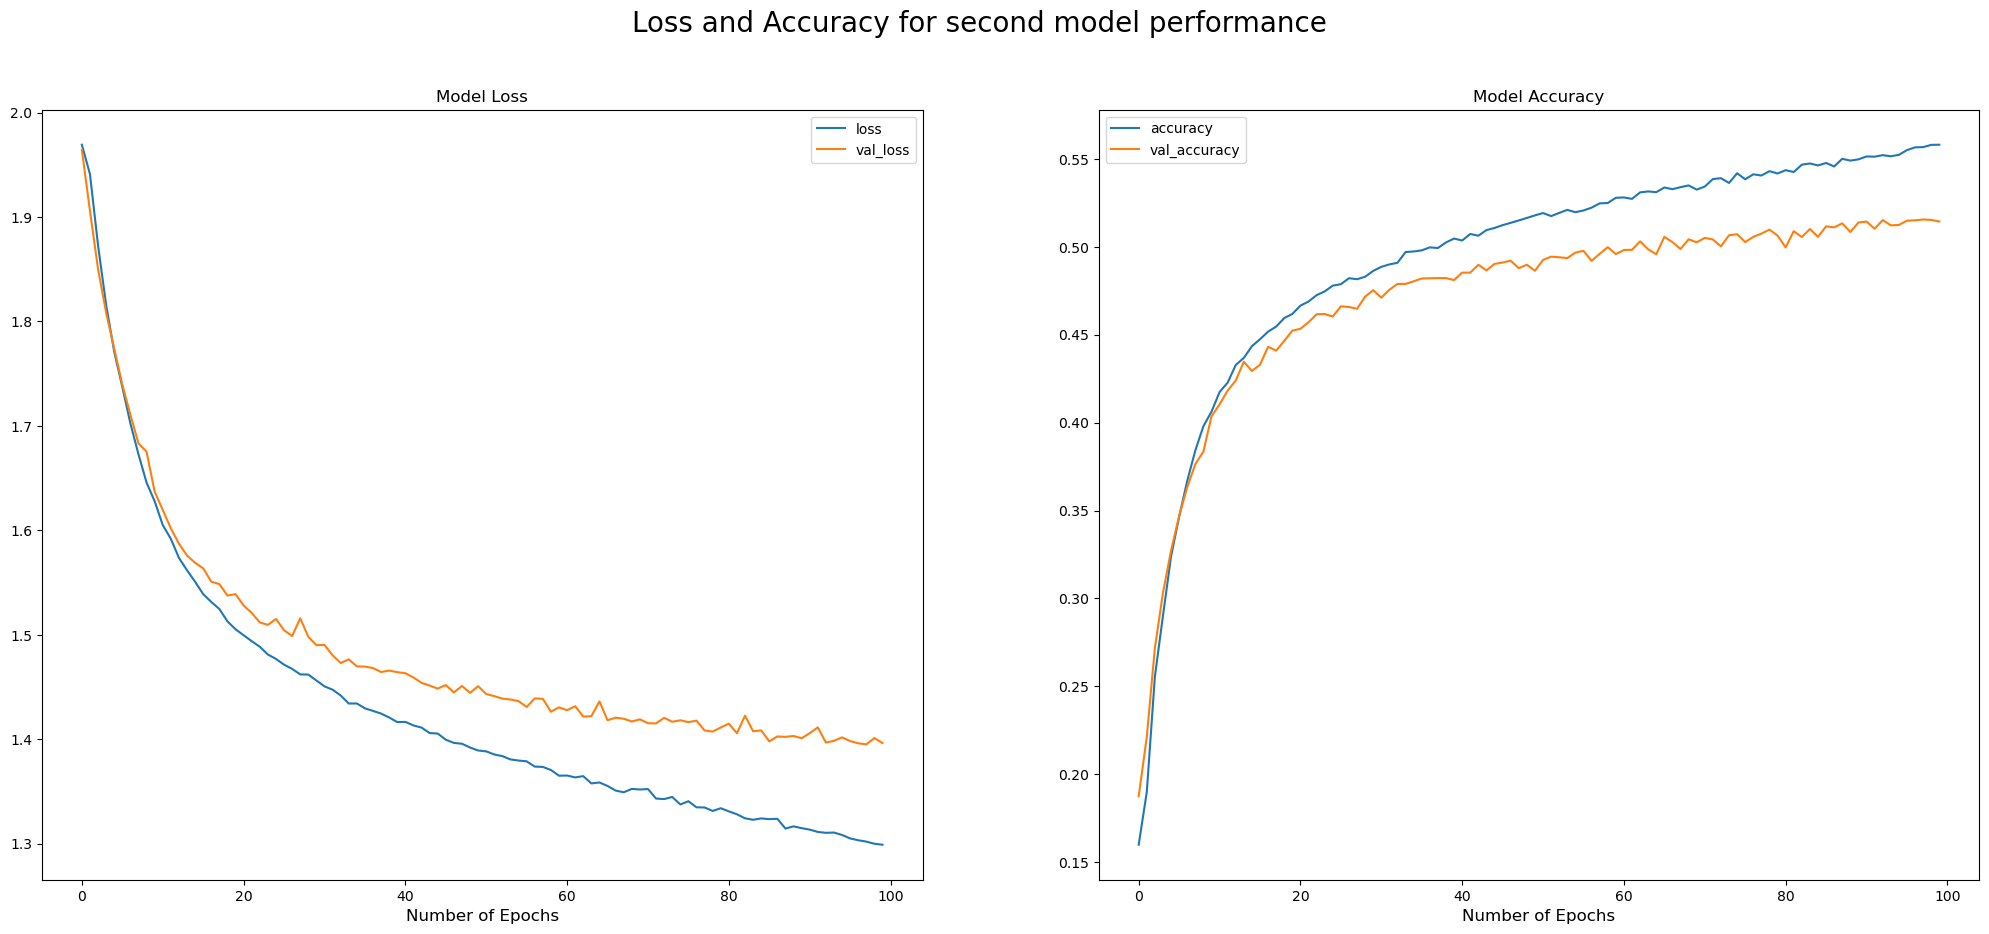

In [20]:
sigmoid_loss = model_info.history['loss']
sigmoid_accuracy = model_info.history['accuracy']
val_sigmoid_loss = model_info.history['val_loss']
val_sigmoid_accuracy = model_info.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy for second model performance', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


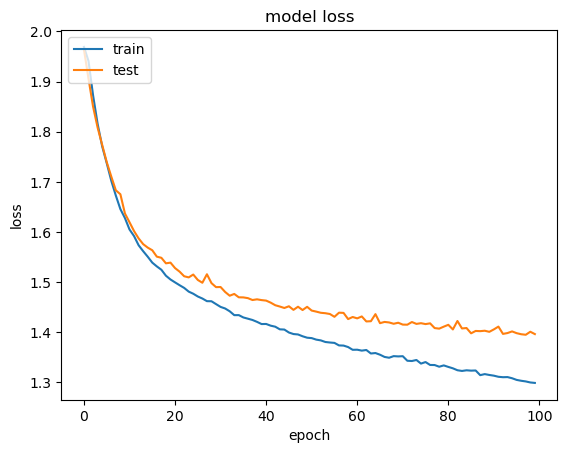

In [21]:
print(model_info.history.keys())

plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Save previous model weights
model.save_weights('./Data/emotion_detector_models/second_model_initial_weights.h5')


In [23]:
#Apply initial model weights to the model to transfer learning from initial run
model.load_weights('./Data/emotion_detector_models/second_model_initial_weights.h5')

Updating sampling to align with batching

In [24]:
# Model 2 train/validation (augment)
# - 9601 images belonging to 7 classes
# - 2276 images belonging to 7 classes

In [25]:
#reducing batch size back down to 512 for improved learning and updating samples based on model 2 paths
batch_size2 = 512

#dramatically increasing epochs to improve accuracy and reduce underfitting
epochs2 = 450
nb_train_samples2 = 9601
nb_validation_samples2 = 2276

In [26]:
model_info2 = model.fit(
            train2_generator,
            steps_per_epoch=nb_train_samples2 // batch_size2,
            epochs=epochs2,
            callbacks = callbacks,
            validation_data=validation2_generator,
            validation_steps=nb_validation_samples2 // batch_size2)


Epoch 1/450
18/18 [==============================] - 54s 3s/step - loss: 1.7229 - accuracy: 0.3652 - val_loss: 1.3855 - val_accuracy: 0.5137
Epoch 2/450
18/18 [==============================] - 50s 3s/step - loss: 1.6728 - accuracy: 0.3851 - val_loss: 1.3798 - val_accuracy: 0.5264
Epoch 3/450
18/18 [==============================] - 51s 3s/step - loss: 1.6531 - accuracy: 0.3901 - val_loss: 1.3841 - val_accuracy: 0.5239
Epoch 4/450
18/18 [==============================] - 51s 3s/step - loss: 1.6384 - accuracy: 0.3977 - val_loss: 1.3680 - val_accuracy: 0.5381
Epoch 5/450
18/18 [==============================] - 50s 3s/step - loss: 1.6288 - accuracy: 0.4073 - val_loss: 1.3604 - val_accuracy: 0.5459
Epoch 6/450
18/18 [==============================] - 51s 3s/step - loss: 1.6104 - accuracy: 0.4116 - val_loss: 1.3815 - val_accuracy: 0.5142
Epoch 7/450
18/18 [==============================] - 50s 3s/step - loss: 1.6277 - accuracy: 0.4083 - val_loss: 1.3633 - val_accuracy: 0.5327
Epoch 8/450
1

18/18 [==============================] - 51s 3s/step - loss: 1.5386 - accuracy: 0.4441 - val_loss: 1.3562 - val_accuracy: 0.5239
Epoch 56/450
18/18 [==============================] - 51s 3s/step - loss: 1.5288 - accuracy: 0.4531 - val_loss: 1.3694 - val_accuracy: 0.5288
Epoch 57/450
18/18 [==============================] - 51s 3s/step - loss: 1.5289 - accuracy: 0.4540 - val_loss: 1.3898 - val_accuracy: 0.5073
Epoch 58/450
18/18 [==============================] - 50s 3s/step - loss: 1.5319 - accuracy: 0.4480 - val_loss: 1.3648 - val_accuracy: 0.5293
Epoch 59/450
18/18 [==============================] - 50s 3s/step - loss: 1.5425 - accuracy: 0.4410 - val_loss: 1.3792 - val_accuracy: 0.5220
Epoch 60/450
18/18 [==============================] - 51s 3s/step - loss: 1.5333 - accuracy: 0.4485 - val_loss: 1.3538 - val_accuracy: 0.5293
Epoch 61/450
18/18 [==============================] - 51s 3s/step - loss: 1.5215 - accuracy: 0.4564 - val_loss: 1.3947 - val_accuracy: 0.5117
Epoch 62/450
18/18 

18/18 [==============================] - 50s 3s/step - loss: 1.4999 - accuracy: 0.4612 - val_loss: 1.3881 - val_accuracy: 0.5161
Epoch 110/450
18/18 [==============================] - 51s 3s/step - loss: 1.4957 - accuracy: 0.4632 - val_loss: 1.3990 - val_accuracy: 0.5103
Epoch 111/450
18/18 [==============================] - 51s 3s/step - loss: 1.4993 - accuracy: 0.4656 - val_loss: 1.3862 - val_accuracy: 0.5146
Epoch 112/450
18/18 [==============================] - 51s 3s/step - loss: 1.4929 - accuracy: 0.4674 - val_loss: 1.3625 - val_accuracy: 0.5259
Epoch 113/450
18/18 [==============================] - 51s 3s/step - loss: 1.4949 - accuracy: 0.4645 - val_loss: 1.3807 - val_accuracy: 0.5234
Epoch 114/450
18/18 [==============================] - 51s 3s/step - loss: 1.5035 - accuracy: 0.4592 - val_loss: 1.3777 - val_accuracy: 0.5176
Epoch 115/450
18/18 [==============================] - 51s 3s/step - loss: 1.5068 - accuracy: 0.4558 - val_loss: 1.3711 - val_accuracy: 0.5181
Epoch 116/450

18/18 [==============================] - 51s 3s/step - loss: 1.4673 - accuracy: 0.4793 - val_loss: 1.3600 - val_accuracy: 0.5342
Epoch 164/450
18/18 [==============================] - 51s 3s/step - loss: 1.4678 - accuracy: 0.4779 - val_loss: 1.3422 - val_accuracy: 0.5444
Epoch 165/450
18/18 [==============================] - 51s 3s/step - loss: 1.4775 - accuracy: 0.4719 - val_loss: 1.3606 - val_accuracy: 0.5347
Epoch 166/450
18/18 [==============================] - 51s 3s/step - loss: 1.4664 - accuracy: 0.4788 - val_loss: 1.3916 - val_accuracy: 0.5161
Epoch 167/450
18/18 [==============================] - 50s 3s/step - loss: 1.4726 - accuracy: 0.4792 - val_loss: 1.3754 - val_accuracy: 0.5186
Epoch 168/450
18/18 [==============================] - 50s 3s/step - loss: 1.4691 - accuracy: 0.4822 - val_loss: 1.3807 - val_accuracy: 0.5161
Epoch 169/450
18/18 [==============================] - 50s 3s/step - loss: 1.4714 - accuracy: 0.4756 - val_loss: 1.3537 - val_accuracy: 0.5312
Epoch 170/450

18/18 [==============================] - 51s 3s/step - loss: 1.4444 - accuracy: 0.4889 - val_loss: 1.3582 - val_accuracy: 0.5303
Epoch 218/450
18/18 [==============================] - 51s 3s/step - loss: 1.4500 - accuracy: 0.4859 - val_loss: 1.3575 - val_accuracy: 0.5293
Epoch 219/450
18/18 [==============================] - 51s 3s/step - loss: 1.4604 - accuracy: 0.4848 - val_loss: 1.3717 - val_accuracy: 0.5142
Epoch 220/450
18/18 [==============================] - 51s 3s/step - loss: 1.4553 - accuracy: 0.4878 - val_loss: 1.3739 - val_accuracy: 0.5142
Epoch 221/450
18/18 [==============================] - 51s 3s/step - loss: 1.4563 - accuracy: 0.4865 - val_loss: 1.3961 - val_accuracy: 0.5054
Epoch 222/450
18/18 [==============================] - 51s 3s/step - loss: 1.4617 - accuracy: 0.4810 - val_loss: 1.3477 - val_accuracy: 0.5347
Epoch 223/450
18/18 [==============================] - 51s 3s/step - loss: 1.4562 - accuracy: 0.4826 - val_loss: 1.3462 - val_accuracy: 0.5312
Epoch 224/450

18/18 [==============================] - 51s 3s/step - loss: 1.4346 - accuracy: 0.4951 - val_loss: 1.3558 - val_accuracy: 0.5337
Epoch 272/450
18/18 [==============================] - 51s 3s/step - loss: 1.4356 - accuracy: 0.4936 - val_loss: 1.3746 - val_accuracy: 0.5244
Epoch 273/450
18/18 [==============================] - 51s 3s/step - loss: 1.4319 - accuracy: 0.4941 - val_loss: 1.3658 - val_accuracy: 0.5229
Epoch 274/450
18/18 [==============================] - 51s 3s/step - loss: 1.4350 - accuracy: 0.4957 - val_loss: 1.3689 - val_accuracy: 0.5249
Epoch 275/450
18/18 [==============================] - 51s 3s/step - loss: 1.4356 - accuracy: 0.4928 - val_loss: 1.3649 - val_accuracy: 0.5249
Epoch 276/450
18/18 [==============================] - 51s 3s/step - loss: 1.4363 - accuracy: 0.4937 - val_loss: 1.3535 - val_accuracy: 0.5269
Epoch 277/450
18/18 [==============================] - 51s 3s/step - loss: 1.4381 - accuracy: 0.4966 - val_loss: 1.3684 - val_accuracy: 0.5312
Epoch 278/450

18/18 [==============================] - 51s 3s/step - loss: 1.4197 - accuracy: 0.5020 - val_loss: 1.3498 - val_accuracy: 0.5356
Epoch 326/450
18/18 [==============================] - 51s 3s/step - loss: 1.4228 - accuracy: 0.5012 - val_loss: 1.3469 - val_accuracy: 0.5342
Epoch 327/450
18/18 [==============================] - 51s 3s/step - loss: 1.4186 - accuracy: 0.5065 - val_loss: 1.3382 - val_accuracy: 0.5337
Epoch 328/450
18/18 [==============================] - 50s 3s/step - loss: 1.4182 - accuracy: 0.5057 - val_loss: 1.3312 - val_accuracy: 0.5366
Epoch 329/450
18/18 [==============================] - 51s 3s/step - loss: 1.4267 - accuracy: 0.4962 - val_loss: 1.3732 - val_accuracy: 0.5234
Epoch 330/450
18/18 [==============================] - 51s 3s/step - loss: 1.4173 - accuracy: 0.4997 - val_loss: 1.3649 - val_accuracy: 0.5288
Epoch 331/450
18/18 [==============================] - 51s 3s/step - loss: 1.4257 - accuracy: 0.5015 - val_loss: 1.3428 - val_accuracy: 0.5400
Epoch 332/450

18/18 [==============================] - 51s 3s/step - loss: 1.4079 - accuracy: 0.5067 - val_loss: 1.3533 - val_accuracy: 0.5322
Epoch 380/450
18/18 [==============================] - 51s 3s/step - loss: 1.4003 - accuracy: 0.5158 - val_loss: 1.3626 - val_accuracy: 0.5220
Epoch 381/450
18/18 [==============================] - 51s 3s/step - loss: 1.4081 - accuracy: 0.5106 - val_loss: 1.3709 - val_accuracy: 0.5244
Epoch 382/450
18/18 [==============================] - 51s 3s/step - loss: 1.4054 - accuracy: 0.5061 - val_loss: 1.3485 - val_accuracy: 0.5376
Epoch 383/450
18/18 [==============================] - 51s 3s/step - loss: 1.4031 - accuracy: 0.5124 - val_loss: 1.3557 - val_accuracy: 0.5352
Epoch 384/450
18/18 [==============================] - 51s 3s/step - loss: 1.4013 - accuracy: 0.5127 - val_loss: 1.3392 - val_accuracy: 0.5420
Epoch 385/450
18/18 [==============================] - 51s 3s/step - loss: 1.4048 - accuracy: 0.5046 - val_loss: 1.3573 - val_accuracy: 0.5327
Epoch 386/450

18/18 [==============================] - 51s 3s/step - loss: 1.3943 - accuracy: 0.5151 - val_loss: 1.3226 - val_accuracy: 0.5420
Epoch 434/450
18/18 [==============================] - 51s 3s/step - loss: 1.3892 - accuracy: 0.5116 - val_loss: 1.3679 - val_accuracy: 0.5288
Epoch 435/450
18/18 [==============================] - 51s 3s/step - loss: 1.3921 - accuracy: 0.5177 - val_loss: 1.3554 - val_accuracy: 0.5381
Epoch 436/450
18/18 [==============================] - 51s 3s/step - loss: 1.4008 - accuracy: 0.5040 - val_loss: 1.3652 - val_accuracy: 0.5239
Epoch 437/450
18/18 [==============================] - 51s 3s/step - loss: 1.4009 - accuracy: 0.5111 - val_loss: 1.3435 - val_accuracy: 0.5391
Epoch 438/450
18/18 [==============================] - 51s 3s/step - loss: 1.3962 - accuracy: 0.5117 - val_loss: 1.3653 - val_accuracy: 0.5278
Epoch 439/450
18/18 [==============================] - 51s 3s/step - loss: 1.3891 - accuracy: 0.5158 - val_loss: 1.3664 - val_accuracy: 0.5303
Epoch 440/450

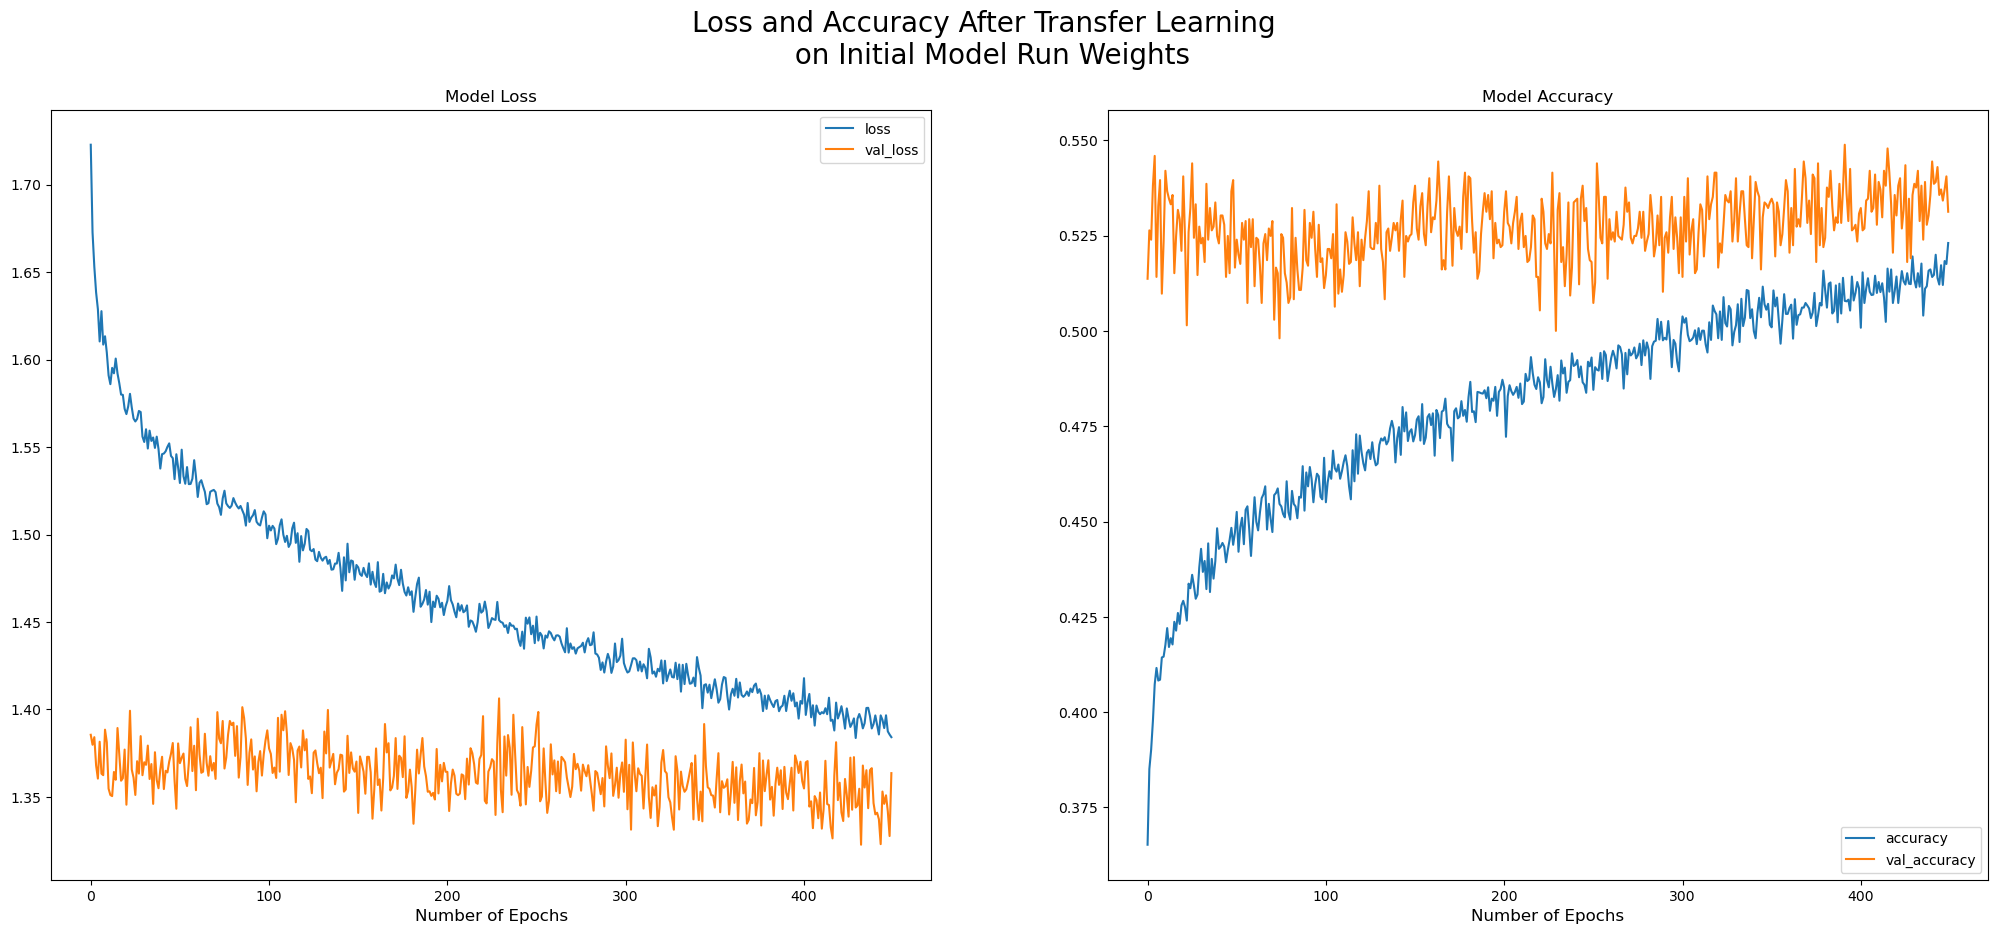

In [27]:
sigmoid_loss = model_info2.history['loss']
sigmoid_accuracy = model_info2.history['accuracy']
val_sigmoid_loss = model_info2.history['val_loss']
val_sigmoid_accuracy = model_info2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info2.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info2.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy After Transfer Learning \n on Initial Model Run Weights', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

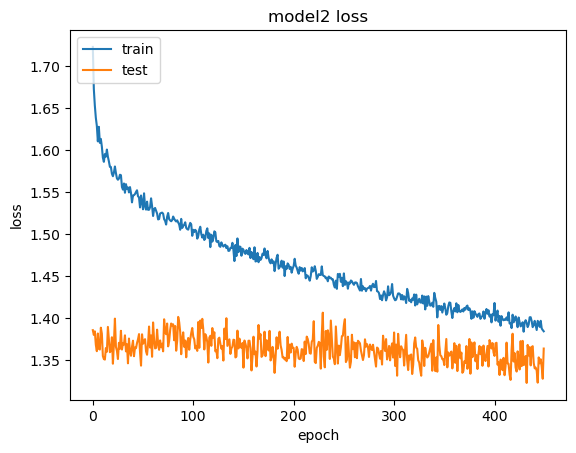

In [28]:
plt.plot(model_info2.history['loss'])
plt.plot(model_info2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Validation

Look at performance on the test set that was retained

In [30]:
# Found 4163 images belonging to 7 classes.

nb_train_samples2 = 9601
nb_validation_samples2 = 2276
nb_test_samples = 4163

# We need to recreate our test generator with shuffle = false
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 4163 images belonging to 7 classes.


In [31]:
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


2022-09-27 08:31:03.124483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 41s 4s/step


In [32]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [33]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [35]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[406   0   0   2   6  55  77]
 [263   0   0   8   4  40  84]
 [134   0   0   9   3  83 315]
 [  1   0   0 675  67   0   2]
 [  9   0   0 110 639   1  11]
 [181   0   0   9   5 194 125]
 [ 17   0   0  81 420  12 115]]


In [36]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.40      0.74      0.52       546
     disgust       0.00      0.00      0.00       399
        fear       0.00      0.00      0.00       544
       happy       0.76      0.91      0.82       745
     neutral       0.56      0.83      0.67       770
         sad       0.50      0.38      0.43       514
    surprise       0.16      0.18      0.17       645

    accuracy                           0.49      4163
   macro avg       0.34      0.43      0.37      4163
weighted avg       0.38      0.49      0.42      4163



/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

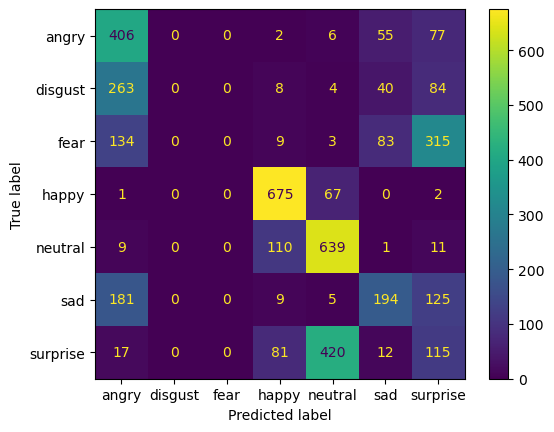

In [37]:

cnf_matrix = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

# Pickling model for use

In [81]:
import joblib        # to save models

# For Saving
path_name = "/Users/charlielosche/Documents/Flatiron/Flatiron_Repos/Capstone_Project/Notebooks/"    # some path


model_name = 'predict_emotion_2.sav' # I think saving it to sav format maybe will help y


joblib.dump(model, path_name + model_name)


INFO:tensorflow:Assets written to: ram://29b33524-c5c9-4af9-9103-ce54514e747f/assets


INFO:tensorflow:Assets written to: ram://29b33524-c5c9-4af9-9103-ce54514e747f/assets


['/Users/charlielosche/Documents/Flatiron/Flatiron_Repos/Capstone_Project/Notebooks/predict_emotion_2.sav']

In [ ]:
# # For loading into IDE or Other Notebook (personal file path - should be updated for your notebook)
# path_name = "/Users/charlielosche/Documents/Flatiron/Flatiron_Repos/Capstone_Project/Notebooks/"    # some path


# model_name = 'predict_emotion_2.sav' # I think saving it to sav format maybe will help here

# joblib.load(path_name + model_name)

# # opening the file- model_jlib
# m_jlib = joblib.load(path_name + model_name)

# m_jlib

In [39]:
# saving model

model.save('./Data/emotion_detector_models/charlie_model/v2_final_model.h5')

### Loading our saved model

In [40]:
classifier = load_model('./Data/emotion_detector_models/charlie_model/v2_final_model.h5')

In [41]:
classifier

## Attempting to replicate above confusion matrix with saved model

In [31]:


# nb_train_samples = 28273
# nb_validation_samples = 3534
nb_train_samples = 28709
nb_validation_samples = 3589

# We need to recreate our validation generator with shuffle = false
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 7178 images belonging to 7 classes.


In [32]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = classifier.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


 2/15 [===>..........................] - ETA: 0s

2022-09-23 15:29:38.120260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 43ms/step


In [33]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [34]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [35]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 479    0   69   62  158  138   52]
 [  67    0    8    9   11   13    3]
 [ 175    0  210   78  175  214  172]
 [  91    0   40 1410   99   65   69]
 [  90    0   76   99  769  171   28]
 [ 175    0  112   94  326  512   28]
 [  40    0   72   47   44   17  611]]


In [36]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.43      0.50      0.46       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.21      0.26      1024
       happy       0.78      0.79      0.79      1774
     neutral       0.49      0.62      0.55      1233
         sad       0.45      0.41      0.43      1247
    surprise       0.63      0.74      0.68       831

    accuracy                           0.56      7178
   macro avg       0.45      0.47      0.45      7178
weighted avg       0.54      0.56      0.54      7178



/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

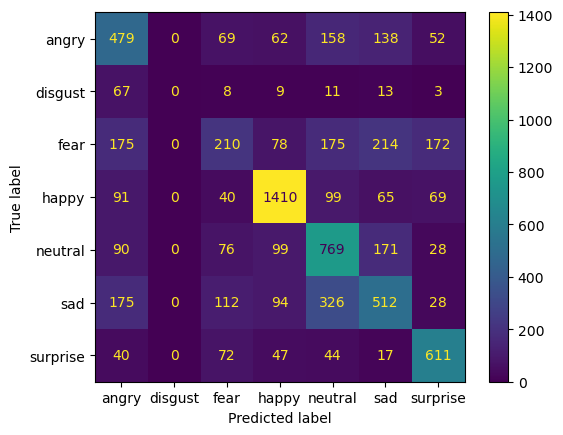

In [37]:

cnf_matrix = confusion_matrix(y_true=validation_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

# Visualize Model Validation

### Get our class labels

In [38]:
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 7178 images belonging to 7 classes.
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


### Let's test on some of validation images

In [42]:

def draw_test(name, pred, im, true_label):
    """NOTE: Any cell using the draw_test() function needs %matplotlib inline
    
    function generates a matplot figure containing
    the original image expanded, and the predicted class vs the actual class"""
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "Predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_COMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "True - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    plt.imshow(expanded_image)
    plt.show()


def getRandomImage(path, img_width, img_height):
    """function loads a random image
    from a random folder in our test path. Used alongside draw_test(), this function can generate a set of
    random images and their respective predicted vs actual classes"""
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return load_img(final_path, target_size = (img_width, img_height),color_mode="grayscale"), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48


In [43]:
# Try to load an imgage using above function
path = './Data/archive_FER_Affect/final_test/' 

img, final_path, true_label = getRandomImage(path, img_width, img_height)

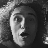

In [44]:
img

In [45]:
final_path

'../Data/archive_FER_Affect/final_test/fear/image0007194.jpg'

In [46]:
true_label

'fear'

In [47]:
## Comenting out new compiler to avoid retraining saved model

In [48]:
# # We use a very small learning rate 
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = RMSprop(learning_rate=0.001),
#               metrics = ['accuracy'])


In [49]:
files = []
predictions = []
true_labels = []

# TRYING TO UPDATE CODE

In [50]:
# predicting images
for i in range(0, 10):
    path = './Data/archive/test/'
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    preds = classifier.predict(images, batch_size = 10)
    classes = np.argmax(preds,axis=1)
    predictions.append(classes)

1/1 [==============================] - 0s 11ms/step


2022-09-27 08:43:25.131200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


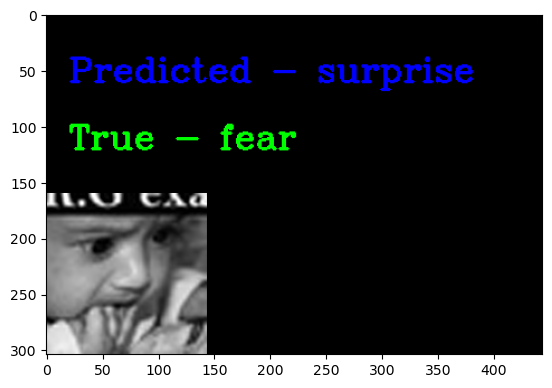

In [51]:
# Attempt generating one image first and it's class
# Any cell using the draw_test() function needs %matplotlib inline
%matplotlib inline


image = cv2.imread((files[0]))
image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
draw_test("Prediction", class_labels[predictions[0][0]], image, true_labels[0])

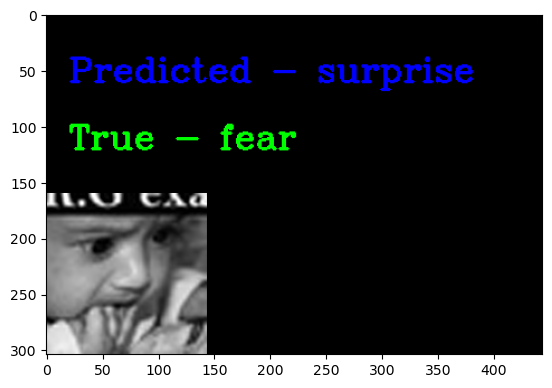

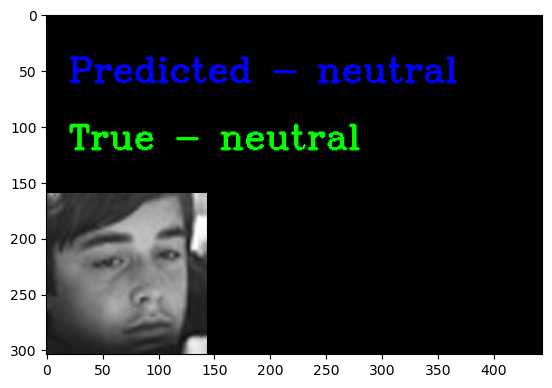

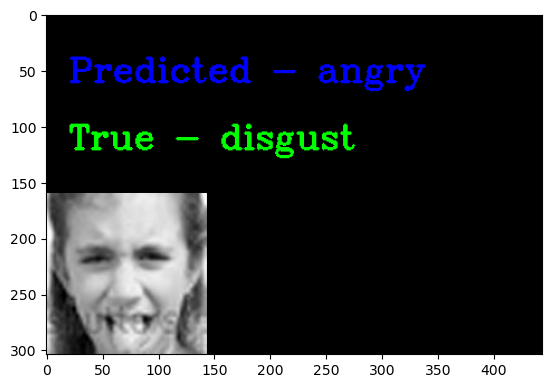

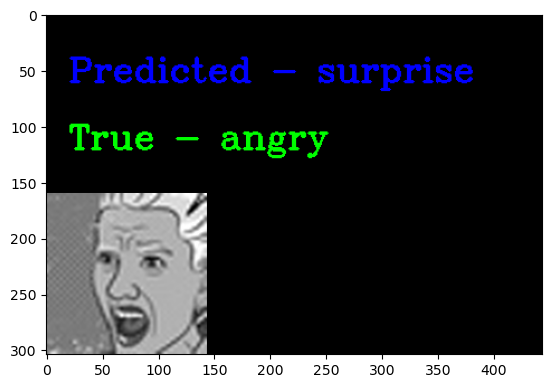

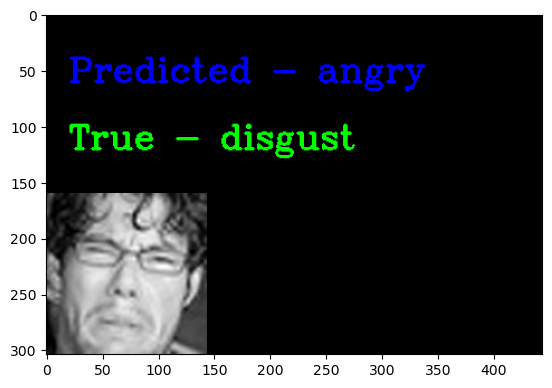

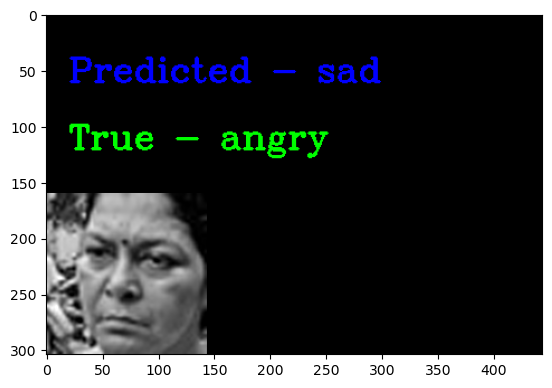

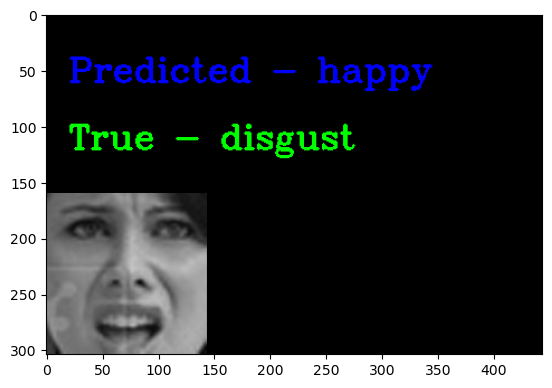

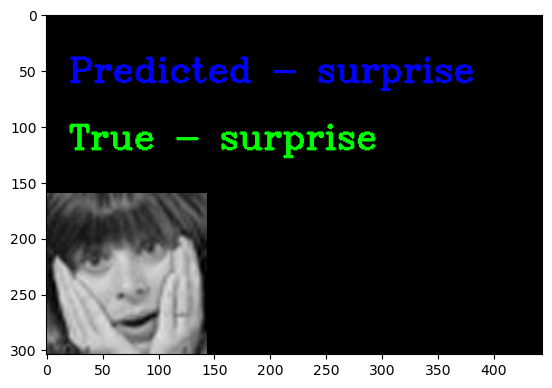

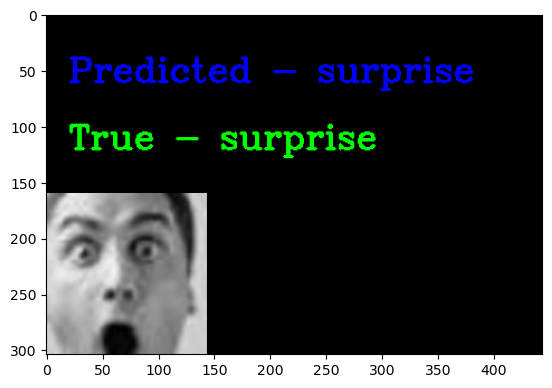

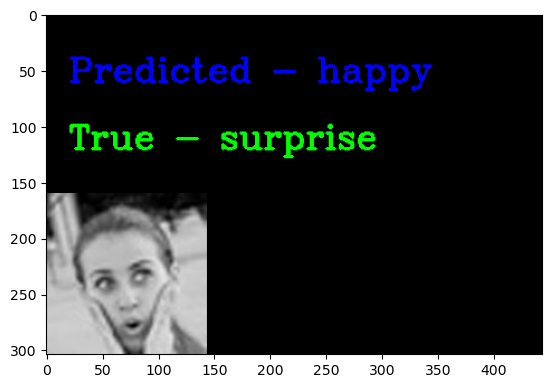

In [52]:
%matplotlib inline

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])

### Test on a single image

In [53]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [59]:
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

In [64]:
%matplotlib inline

img = cv2.imread("./Data/unseen_images/Paige2_Happy.jpeg")
rects, faces, image = face_detector(img)


1/1 [==============================] - 0s 12ms/step


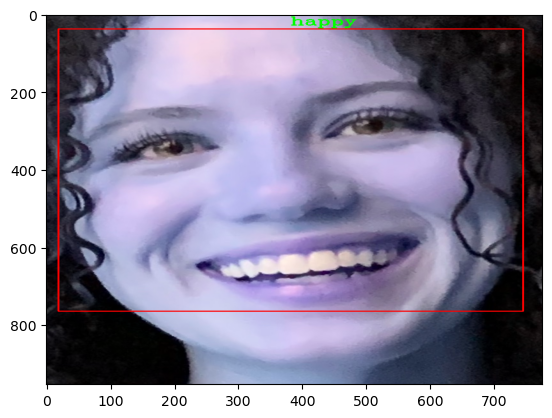

In [65]:

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    
    #Show the image with matplotlib
    plt.imshow(image, aspect='auto')
    plt.show()

In [67]:
# Trying on fearful baby pic - seems neutral imo
%matplotlib inline

img2 = cv2.imread("./Data/archive_FER_Affect/test2/fear/image0030495.jpg")
rects, faces, image = face_detector(img2)


1/1 [==============================] - 0s 17ms/step


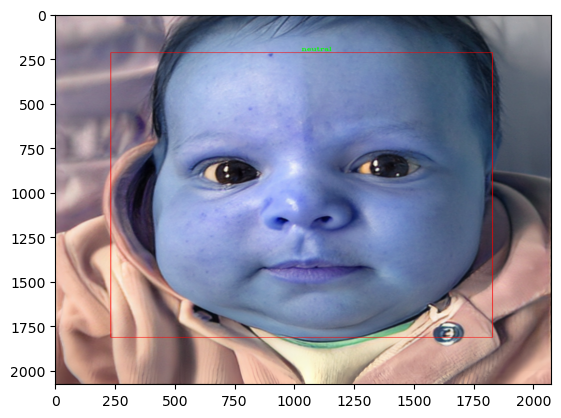

In [68]:
i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    
    #Show the image with matplotlib
    plt.imshow(image, aspect='auto')
    plt.show()

### Let's try this on our webcam


In [53]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


In [54]:
cap.release()
cv2.destroyAllWindows()      